### Imports

In [33]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, Model
import keras as k

import sklearn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from keras.initializers import *

from matplotlib import pyplot as plt
import seaborn as sns
import scipy

from datetime import datetime

import pickle

from PIL import Image

from custom_class import *

print(f"pd.__version__: {pd.__version__}")
print(f"tf.__version__: {tf.__version__}")

image_size = (120, 160)

pd.__version__: 2.2.3
tf.__version__: 2.15.1


### Read file path and labels to list

In [34]:
dataset_dir = "/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Captured_data/processed"

dataset_dir_list = [
    os.path.join(dataset_dir, folder)
    for folder in os.listdir(dataset_dir)
    if os.path.isdir(os.path.join(dataset_dir, folder))
]

csv_path_list = [os.path.join(dir, "_labels.csv") for dir in dataset_dir_list]

csv_df = None

for csv_path in csv_path_list:
    df = pd.read_csv(csv_path, index_col="image_id")
    # undersampling
    if "_go" in csv_path or "T_" in csv_path:
        df = df.sample(frac=1.0, random_state=42)
    # oversampling
    elif "_red" in csv_path:
        df = df.sample(frac=1.6, replace=True, random_state=42)
    df.index = csv_path.split("/")[-2] + "/" + df.index
    csv_df = pd.concat([csv_df, df])

csv_df = csv_df[["speed", "red_light", "obj_ahead"]]

display(csv_df)

,speed,red_light,obj_ahead
image_id,,,
eight_go/1741810023570_85_35,1.0,0.0,0.0
eight_go/1741809449393_100_35,1.0,0.0,0.0
eight_go/1741809905430_105_35,1.0,0.0,0.0
eight_go/1741810567199_105_35,1.0,0.0,0.0
eight_go/1741810598515_90_35,1.0,0.0,0.0
...,...,...,...
T_right/1741869145200_110_35,1.0,0.0,0.0
T_right/1741869224297_90_35,1.0,0.0,0.0
T_right/1741873554255_115_35,1.0,0.0,0.0


Check the data

(array([4877.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1004.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

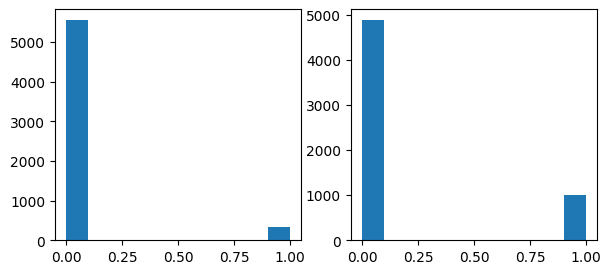

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
ax[0].hist(csv_df["red_light"])
ax[1].hist(csv_df["obj_ahead"])

In [36]:
rs = 783

X = np.array(csv_df.index)
y = np.array(csv_df[["speed", "red_light", "obj_ahead"]])
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.15, random_state=rs
# )
# X_train, X_val, y_train, y_val = train_test_split(
#     X_train, y_train, test_size=(0.15 / 0.85), random_state=rs
# )
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=rs)

print(np.unique(np.array(y), axis=0))

cases = np.unique(np.array(y), axis=0)

[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [37]:
X_train_path = [
    os.path.join(dataset_dir, str(image_id) + ".png") for image_id in X_train
]
X_val_path = [os.path.join(dataset_dir, str(image_id) + ".png") for image_id in X_val]

In [38]:
def decode_img(
    img,
):  # -> Any | defaultdict | Any | list | None | object | Tensor | ...:
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_path(file_path, labels):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, labels


def image_id_to_path(image_id, labels):
    image_path = tf.strings.join(
        [dataset_dir, "/", tf.as_string(image_id), ".png"]
    )  # Assuming images are .jpg
    return image_path, labels

In [39]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train_path, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val_path, y_val))

train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

train_ds_length = tf.data.experimental.cardinality(train_ds).numpy()
print(train_ds_length)
val_ds_length = tf.data.experimental.cardinality(val_ds).numpy()
print(val_ds_length)

4704
1177


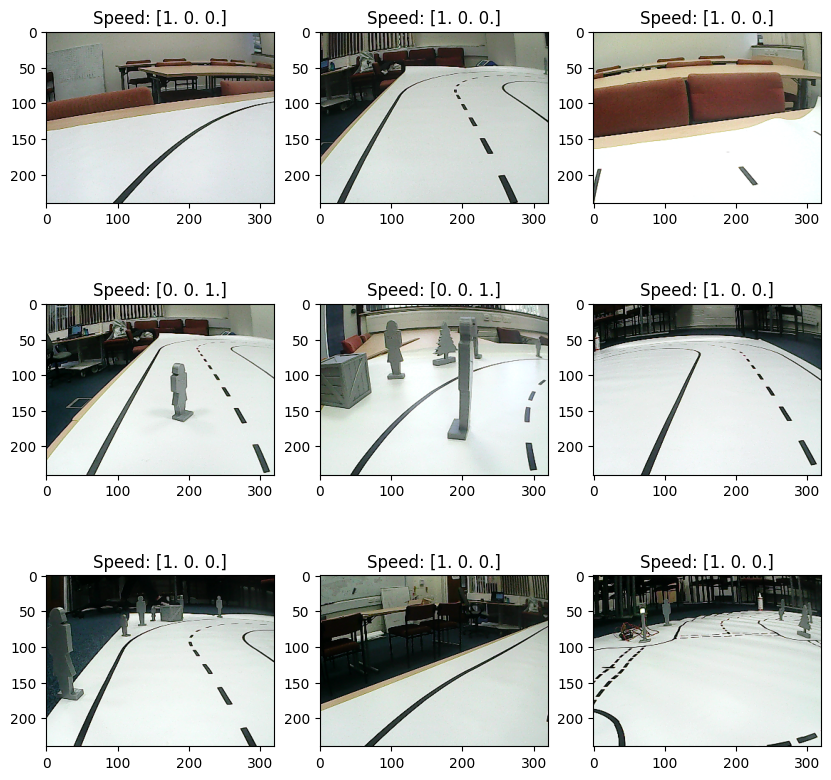

In [40]:
plt.figure(figsize=(10, 10))
i = 0

for image, labels in train_ds.take(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("float32"))
    labels = labels.numpy()
    plt.title(f"Speed: {labels}")
    i += 1

In [41]:
def visualise(original, augmented):
    fig = plt.figure()
    plt.subplot(1, 2, 1)
    plt.title("Original image")
    plt.imshow(original.numpy().astype("float32"))

    plt.subplot(1, 2, 2)
    plt.title("Augmented image")
    plt.imshow(augmented.numpy().astype("float32"))

In [42]:
rotate_by_degree = 5
random_rotate = keras.layers.RandomRotation(rotate_by_degree / 360)


def augment(image, labels, seed=None):
    # Deal with the random seed
    if seed == None:
        seed = tf.random.uniform(shape=[2], maxval=10000, dtype=tf.int32)
    else:
        seed = tf.constant([seed, seed], dtype=tf.int32)

    image = tf.image.stateless_random_brightness(image, 0.3, seed)
    image = tf.image.stateless_random_contrast(image, 0.75, 1.25, seed)
    image = tf.image.stateless_random_hue(image, 0.05, seed)
    image = tf.image.stateless_random_saturation(image, 0.7, 1.2, seed)
    image = tf.image.stateless_random_jpeg_quality(image, 80, 100, seed)

    image = random_rotate(image)

    # crop image
    image = tf.image.stateless_random_crop(image, size=[210, 280, 3], seed=seed)

    # resize image back to 240x320
    image = tf.image.resize(image, [240, 320])

    return image, labels

Test augment function

20
Augmented image shape: (240, 320, 3)


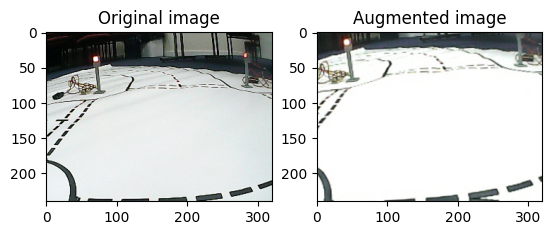

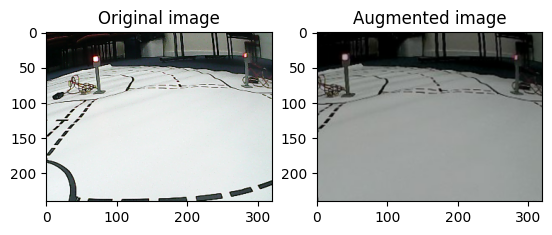

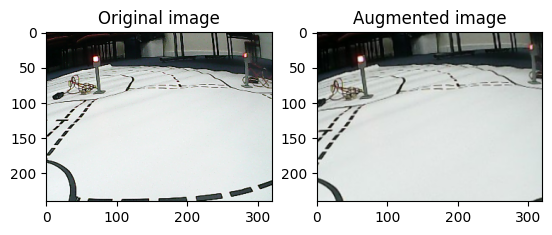

In [43]:
skip = 20
# skip+=1
print(skip)
for i in range(3):
    for image, labels in train_ds.skip(skip).take(1):
        augmented_image, speed = augment(image, labels, None)
        visualise(image, augmented_image)

for image, labels in train_ds.take(1):
    aug_image, aug_labels = augment(image, labels)
    print(f"Augmented image shape: {aug_image.shape}")

In [44]:
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

In [45]:
def scale_ds(image, labels):
    # Range of input image: [0, 1]
    return image * 2 - 1.0, labels


train_ds = train_ds.map(scale_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(scale_ds, num_parallel_calls=tf.data.AUTOTUNE)

In [46]:
def resize_ds(image, labels):
    return tf.image.resize(image, [image_size[0], image_size[1]]), labels


train_ds = train_ds.map(resize_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(resize_ds, num_parallel_calls=tf.data.AUTOTUNE)

In [47]:
for image, labels in train_ds.take(1):
    print(f"Image shape: {image.shape}")
    print(f"Labels: {labels}")

Image shape: (120, 160, 3)
Labels: [1. 0. 0.]


In [48]:
def rephrase_ds(image, labels):
    # return image, {"speed1_output": speed, "speed2_output": speed, "speed3_output": speed}
    # speed_dict = {}
    # for i in range(10):
    #     speed_dict[f"speed{i}_output"] = speed

    return image, labels


train_ds = train_ds.map(rephrase_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(rephrase_ds, num_parallel_calls=tf.data.AUTOTUNE)

In [49]:
batch_size = 32


def configure_for_performance(ds, shuffle: bool, batch: bool):
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    if batch:
        ds = ds.batch(batch_size, drop_remainder=True)
    else:
        ds = ds.batch(1, drop_remainder=False)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds


train_ds = train_ds.repeat()
val_ds = val_ds.repeat()
train_ds = configure_for_performance(train_ds, shuffle=True, batch=True)
val_ds = configure_for_performance(val_ds, shuffle=False, batch=True)

### Build model

In [50]:
# print(y_train)
# class_weight = compute_class_weight("balanced", classes=np.array([0, 1]), y=y_train)
# class_weight_dict = {0: class_weight[0], 1: class_weight[1]}
# print(class_weight_dict)

In [51]:
image_shape = (image_size[0], image_size[1], 3)

base_model = keras.applications.MobileNetV3Small(
    include_top=False,
    weights="imagenet",
    input_shape=image_shape,
    pooling=None,
    include_preprocessing=False,
)
base_model.trainable = False

print(base_model.output.shape)

(None, 4, 5, 576)


In [52]:
feature_extractor = base_model.output

print(feature_extractor.shape)

s_model = []


# model 0
i = 0

s = feature_extractor
s = layers.Conv2D(
    96,
    (3, 3),
    (2, 2),
    padding="same",
    kernel_initializer="he_uniform",
    name=f"s{i}_conv_2",
)(feature_extractor)
s = layers.BatchNormalization(name=f"s{i}_bn_2")(s)
s = layers.Activation("relu", name=f"s{i}_relu_2")(s)
s = layers.GlobalAveragePooling2D(name=f"s{i}_GAP")(s)
s = layers.Dense(
    196, activation="relu", kernel_initializer="he_uniform", name=f"s{i}_dense_2"
)(s)
s = layers.Dropout(0.5, name=f"s{i}_dropout_2")(s)
s = layers.Dense(
    128, activation="relu", kernel_initializer="he_uniform", name=f"s{i}_dense_1"
)(s)
s = layers.Dropout(0.5, name=f"s{i}_dropout")(s)
s = layers.Dense(3, activation="softmax", name=f"s{i}_output")(s)

s_model.append(s)


outputs_dict = {}
loss_dict = {}
metrics_dict = {}

for i in range(len(s_model)):
    outputs_dict[f"speed{i}_output"] = s_model[i]
    loss_dict[f"speed{i}_output"] = "categorical_crossentropy"
    metrics_dict[f"speed{i}_output"] = ["mse", "accuracy"]


model = Model(inputs=base_model.input, outputs=outputs_dict, name="speed_model")

learning_rate = 0.0010

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss=loss_dict,
    metrics=metrics_dict,
)

# model.summary()

(None, 4, 5, 576)


In [53]:
# sub_model = Model(inputs=feature_extractor, outputs=outputs_dict,
#                                                 name="speed_model")
# tf.keras.utils.plot_model(
#     sub_model,
#     show_shapes=True,  # Show input/output shapes
#     show_layer_names=True,  # Show layer names (e.g., "angle_hidden_2")
#     expand_nested=False,  # Keep it flat (no base_model nesting)
#     show_layer_activations=True,
#     dpi=96,  # Image resolution
# )

# print("Saved model image: model.png")

In [54]:
# def lr_schedule(epoch, lr):
#     FIRST_N_EPOCHS = 2

#     initial_lr = learning_rate
#     if epoch < FIRST_N_EPOCHS:
#         return max(initial_lr * 2, 0.002)
#     decay = 0.42
#     return initial_lr / (1 + ((epoch-FIRST_N_EPOCHS) // 3) * decay)

# # for epoch in range(100):
# #     print(f"Epoch {epoch+1:2d}: {lr_schedule(epoch, 0):.6f}")

### Train model

In [55]:
current_epoch = 1
NUM_OF_EPOCHS = 50


checkpoint = keras.callbacks.ModelCheckpoint(
    filepath="checkpoints/model_epoch_{epoch:02d}.keras",
    save_weights_only=False,
    save_freq="epoch",
    verbose=1,
)


# Use this lr_schedule when re-gen data every epoch
def lr_schedule(epoch, lr):
    FIRST_N_EPOCHS = 2
    epoch = current_epoch - 1
    initial_lr = learning_rate
    if epoch < FIRST_N_EPOCHS:
        # return 0.002
        return max(initial_lr * 2, 0.002)
    # elif epoch > 46:
    #     return 0.0001
    decay = 0.42
    return initial_lr / (1 + ((epoch - FIRST_N_EPOCHS) // 3) * decay)
    # return max(initial_lr / (1 + ((epoch-FIRST_N_EPOCHS) // 3) * decay), 0.0001)


lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)


history_callback = keras.callbacks.History()

# outputs_dict = {}
# loss_dict = {}
# metrics_dict = {}

# for i in range(len(s_model)):
#     outputs_dict[f'speed{i}_output'] = s_model[i]
#     loss_dict[f'speed{i}_output'] = WeightedMeanSquaredError(class_weight_dict)
#     metrics_dict[f'speed{i}_output'] = ["mse", "accuracy"]

try:
    for i in range(NUM_OF_EPOCHS):
        print(f"\n{50*'*'}\nCurrent epoch: {current_epoch}", end="")

        if i == 40:
            for layer in base_model.layers[:-6]:
                layer.trainable = True            

        checkpoint = keras.callbacks.ModelCheckpoint(
            filepath=f"checkpoints/model_epoch_{current_epoch:02d}.keras",
            save_weights_only=False,
            save_freq="epoch",
            verbose=1,
        )

        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=1,
            steps_per_epoch=train_ds_length // batch_size,
            validation_steps=val_ds_length // batch_size,
            callbacks=[checkpoint, history_callback, lr_scheduler],
            verbose=1,
        )

        current_epoch += 1

except KeyboardInterrupt:
    print("Stopped early—saving history")
    with open("training_history.pkl", "wb") as f:
        pickle.dump(history_callback.history, f)


**************************************************
Current epoch: 1
Epoch 1: LearningRateScheduler setting learning rate to 0.002.
146/147 [============================>.] - ETA: 0s - loss: 0.2640 - mse: 0.0471 - accuracy: 0.9022
Epoch 1: saving model to checkpoints/model_epoch_01.keras
147/147 [==============================] - 16s 78ms/step - loss: 0.2625 - mse: 0.0468 - accuracy: 0.9028 - val_loss: 0.1028 - val_mse: 0.0165 - val_accuracy: 0.9696 - lr: 0.0020

**************************************************
Current epoch: 2
Epoch 1: LearningRateScheduler setting learning rate to 0.002.
147/147 [==============================] - ETA: 0s - loss: 0.1077 - mse: 0.0188 - accuracy: 0.9626
Epoch 1: saving model to checkpoints/model_epoch_02.keras
147/147 [==============================] - 14s 81ms/step - loss: 0.1077 - mse: 0.0188 - accuracy: 0.9626 - val_loss: 0.0496 - val_mse: 0.0104 - val_accuracy: 0.9748 - lr: 0.0020

**************************************************
Current epoch:

### Save model and plot

In [56]:
# temp = history_callback.history
# mse_dict = {}
# for key in temp.keys():
#   if key.endswith("mse"):
#     # print(f"{key}: {temp[key][-1]}")
#     mse_dict[key] = temp[key][-1]

# for i in range(int(len(mse_dict)/2)):
#   for key in mse_dict.keys():
#     if str(i) in key:
#       print(f"{key:20s}: {mse_dict[key]}")
# #   print(list(mse_dict.keys())[i])
# #   if mse_dict.keys[i].contains(i):
#     # print(f"{mse_dict.keys()[i]}: {mse_dict[mse_dict.keys()[i]]}")

In [57]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")  # Format: YYYYMMDD_HHMM
name_template = f'speed_model_{timestamp}'

folder_path = f"Models/{name_template}"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

filename = f"{folder_path}/{name_template}.keras"
model.save(filename)
filename = f"{folder_path}/{name_template}.weights.h5"
model.save_weights(filename)

history = history_callback.history

filename = f"{folder_path}/{name_template}_history.pkl"
with open(filename, 'wb') as f:
    pickle.dump(history, f)

loss
accuracy


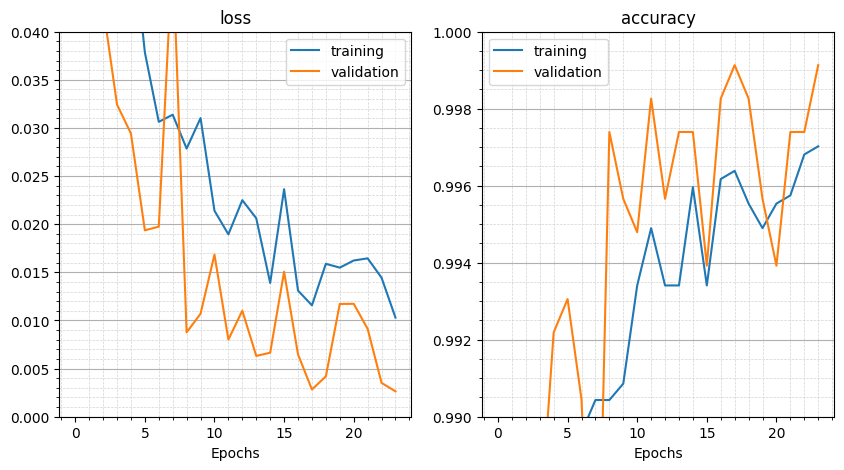

In [58]:
history = history_callback.history
wanted = ["loss", "accuracy"]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax = ax.ravel()

for i in range(len(ax)):
    print(wanted[i])
    for key in history.keys():
        if key.endswith(wanted[i]):
            legend = "training"
            if "val" in key:
                legend = "validation"
            ax[i].plot(history[key], label=legend)
            ax[i].set_title(wanted[i])
            ax[i].set_xlabel("Epochs")
            ax[i].legend()
            ax[i].minorticks_on()
            ax[i].grid(True, axis="y")
            ax[i].grid(which='minor', linestyle='--', linewidth=0.5, color='lightgray')

ax[0].set_ylim(0, 0.04)
ax[1].set_ylim(0.99, 1)            

fig.savefig(f"{folder_path}/{name_template}_performance.png")

In [59]:
# old_csv_df = csv_df

In [60]:
val_ds = tf.data.Dataset.from_tensor_slices((X_val_path, y_val))
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(scale_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(resize_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(rephrase_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = configure_for_performance(val_ds, shuffle=False, batch=False)

In [61]:
preds = model.predict(val_ds)

1177/1177 [==============================] - 9s 7ms/step


In [62]:
pred = preds[list(preds.keys())[0]]
pred = np.argmax(pred, axis=1)
true_val = np.argmax(y_val, axis=1)

/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Captured_data/processed/eight_go/1741810901057_80_35.png
/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Captured_data/processed/eight_obj/1741812041645_90_0.png


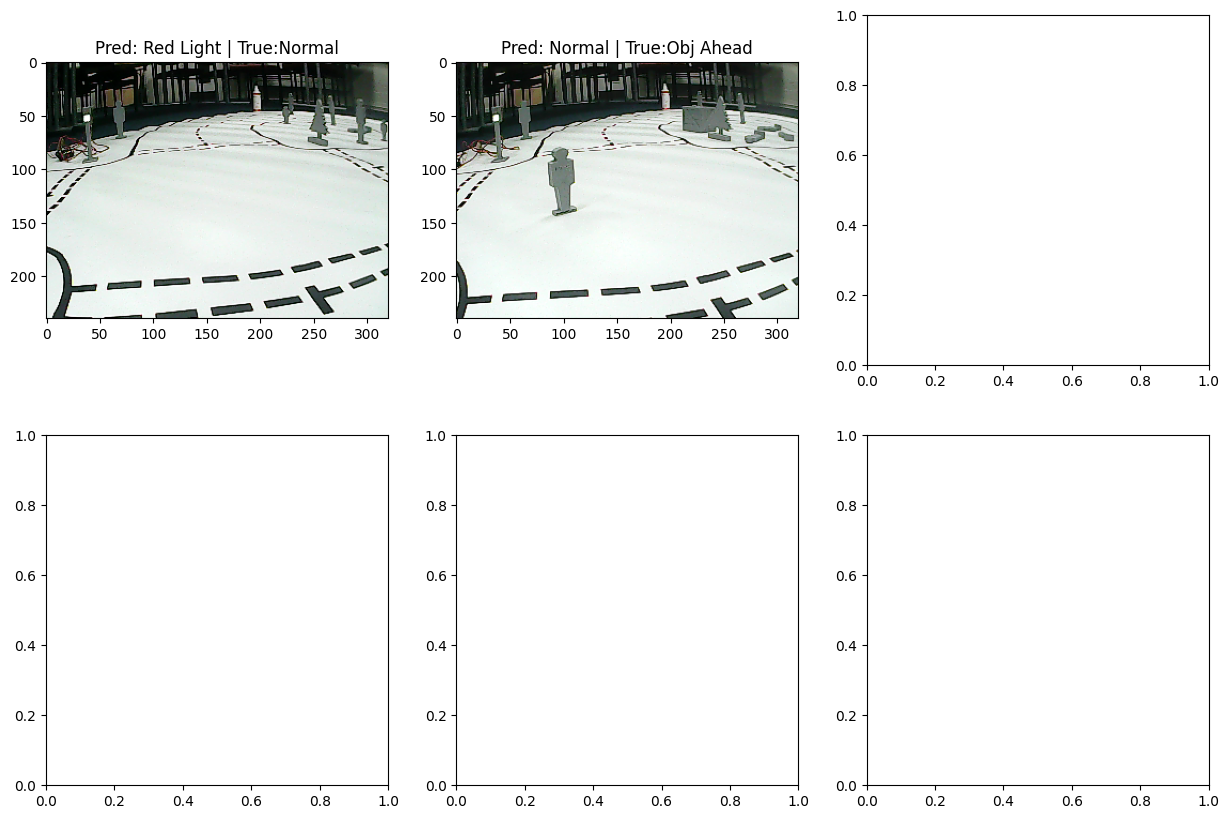

In [63]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.ravel()

image_count = 0

interpretation = {
    0: "Normal",
    1: "Red Light",
    2: "Obj Ahead"
}

for i in range(len(pred)):
    if pred[i] != true_val[i]:
        image = Image.open(X_val_path[i])
        print(X_val_path[i])
        ax[image_count].imshow(image)
        ax[image_count].set_title(f"Pred: {interpretation[pred[i]]} | True:{interpretation[true_val[i]]}")
        image_count += 1
        # print(f"{i}: {pred[i]} | {true_val[i]}")

In [64]:
dataset_dir = "/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Dataset/machine-learning-in-science-ii-2025"
# dataset_dir = "/kaggle/input/machine-learning-in-science-ii-2025"

csv_path = os.path.join(dataset_dir, "training_norm.csv")
csv_df = pd.read_csv(csv_path, index_col="image_id")

training_data_dir = os.path.join(dataset_dir, "training_data", "training_data")

# there is one speed > 1. So change it.
csv_df.loc[csv_df["speed"] > 1, "speed"] = 1

csv_df.drop(columns=["angle"], inplace=True)
csv_df = csv_df[csv_df.index.isin(old_csv_df.index)]

X = np.array(csv_df.index)
y = np.array(csv_df["speed"])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=rs)

X_val_path = [
    os.path.join(training_data_dir, str(image_id) + ".png") for image_id in X_val
]

val_ds = tf.data.Dataset.from_tensor_slices((X_val_path, y_val))
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
# val_ds = val_ds.map(enhance_red, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(scale_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(rephrase_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = configure_for_performance(val_ds, shuffle=False, batch=False)

# model = keras.models.load_model("/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Models/speed_model_20250307_1641/speed_model_20250307_1641.keras")

pred = model.predict(val_ds)

NameError: name 'old_csv_df' is not defined

In [ ]:
y_pred = []
for key in pred.keys():
    print(key, end=", ")
    temp = pred[key][:, 0]
    y_pred.append(temp)

y_pred_mean = np.mean(y_pred, axis=0)

# y_pred.append(y_pred_mean)

y_pred = np.array(y_pred)
y_pred = y_pred - 0.5

y_pred = y_pred.T


def y_pred_map(y_pred):
    if abs(np.mean(y_pred)) > 0.35:
        return np.sign(np.mean(y_pred)) * 0.5 + 0.5
        return round(np.mean(y_pred), 1) + 0.5
    else:
        return np.mean(y_pred) + 0.5


y_pred_2 = []

for i in range(len(y_pred)):
    y_pred_2.append(y_pred_map(y_pred[i]))


y_pred_mean = (np.mean(y_pred, axis=1) > 0).astype(int)

speed0_output, speed1_output, speed2_output, speed3_output, speed4_output, speed5_output, speed6_output, speed7_output, speed8_output, speed9_output, 

In [ ]:
y_pred = []
for key in pred.keys():
    print(key, end=", ")
    temp = pred[key][:, 0]
    y_pred.append(temp)

y_pred_mean = np.mean(y_pred, axis=0)

# y_pred.append(y_pred_mean)

y_pred = np.array(y_pred)
y_pred = y_pred - 0.5

y_pred = y_pred.T


def y_pred_map(y_pred, threshold):
    if abs(np.mean(y_pred)) > threshold:
        return np.sign(np.mean(y_pred)) * 0.5 + 0.5
        return round(np.mean(y_pred), 1) + 0.5
    else:
        return np.mean(y_pred) + 0.5


threshold = 0.2

while True:
    y_pred_2 = []

    for i in range(len(y_pred)):
        y_pred_2.append(y_pred_map(y_pred[i], threshold))

    print(f"Threshold: {threshold:.2f}", end="    ")
    print(sum((y_val - y_pred_2) ** 2) / len(y_val))

    threshold += 0.02
    if threshold > 0.5:
        break

speed0_output, speed1_output, speed2_output, speed3_output, speed4_output, speed5_output, speed6_output, speed7_output, speed8_output, speed9_output, Threshold: 0.20    0.012459610676540818
Threshold: 0.22    0.012459610676540818
Threshold: 0.24    0.012270532143684417
Threshold: 0.26    0.012061410855601223
Threshold: 0.28    0.012061410855601223
Threshold: 0.30    0.011916347401221107
Threshold: 0.32    0.011800948837091462
Threshold: 0.34    0.01169795616184452
Threshold: 0.36    0.011582373674922961
Threshold: 0.38    0.011488166649863584
Threshold: 0.40    0.011493587623527382
Threshold: 0.42    0.011530488215391096
Threshold: 0.44    0.011540722874078488
Threshold: 0.46    0.01154876324600486
Threshold: 0.48    0.011479375335969697


speed0_output, speed1_output, speed2_output, speed3_output, speed4_output, speed5_output, speed6_output, speed7_output, speed8_output, speed9_output, 
[1 0 1 ... 0 1 0]


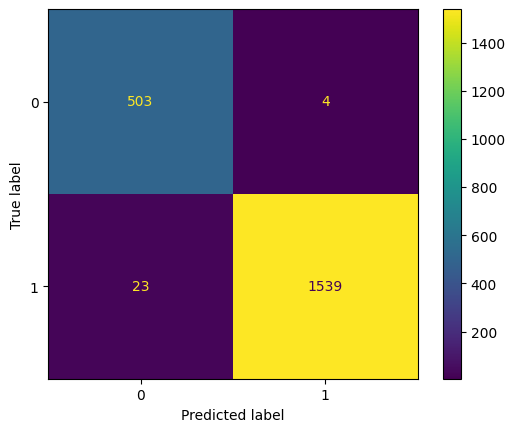

IndexError: index 27 is out of bounds for axis 0 with size 27

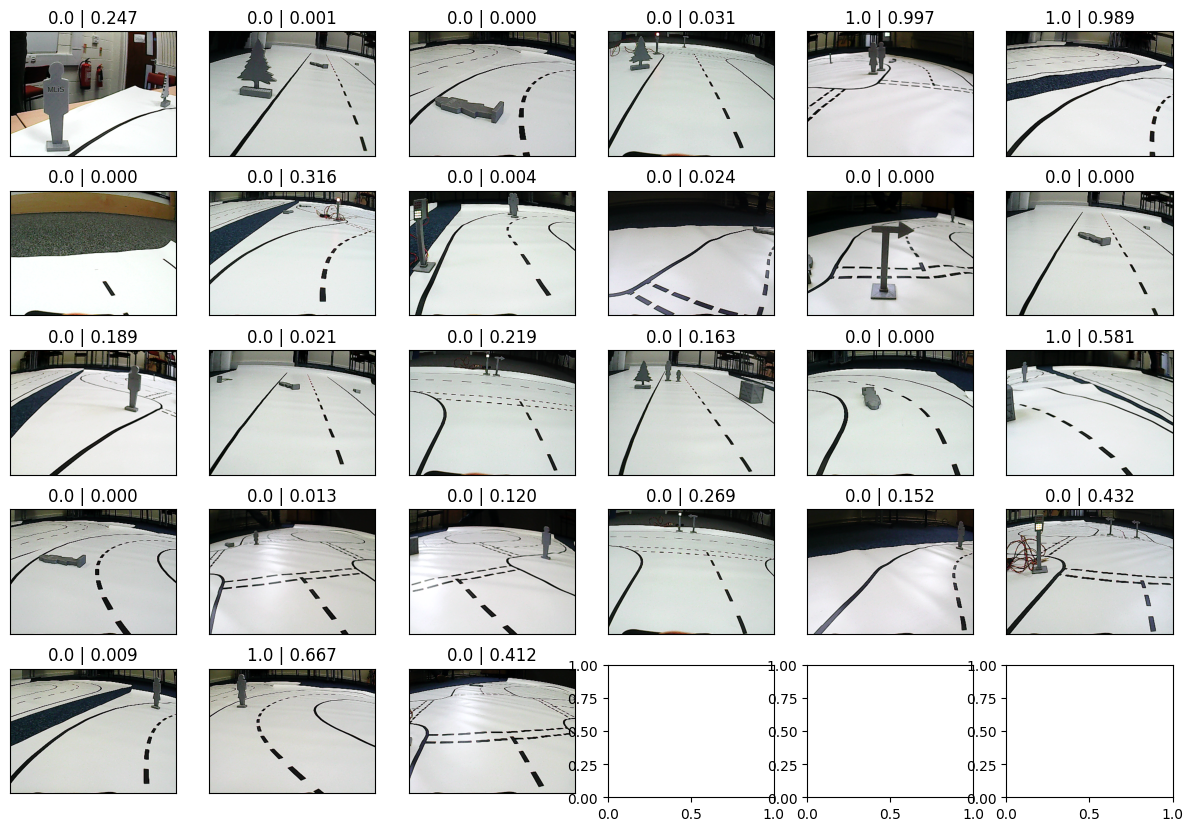

In [ ]:
y_pred = []
for key in pred.keys():
    print(key, end=", ")
    temp = pred[key][:, 0]
    y_pred.append(temp)

print()

y_pred = np.mean(y_pred, axis=0)
y_pred_value = y_pred

y_pred = (y_pred > 0.5).astype(int)
y_val

print(y_pred)

cm = sklearn.metrics.confusion_matrix(y_val, y_pred)

disp = sklearn.metrics.ConfusionMatrixDisplay(cm)

disp.plot()

plt.savefig("confusion_matrix.png")
plt.show()

wrong_id = []
wrong_label = []
wrong_pred = []
wrong_pred_values = []

for i in range(len(y_pred)):
    if y_pred[i] != y_val[i]:
        wrong_id.append(X_val[i])
        wrong_label.append(int(y_val[i]))
        wrong_pred.append(y_pred[i])
        wrong_pred_values.append(y_pred_value[i])
        # print(f"Id: {X_val[i]:5d}, Label: {int(y_val[i])}, Pred: {y_pred[i]}")

wrong_df = pd.DataFrame(
    {
        "id": wrong_id,
        "label": wrong_label,
        "pred": wrong_pred,
        "value": wrong_pred_values,
    }
)
wrong_df.set_index("id", inplace=True)
wrong_df.sort_index(inplace=True)
# print(wrong_df)

fig, ax = plt.subplots(5, 6, figsize=(15, 10))
ax = ax.ravel()

for i in range(len(ax)):
    img_path, _ = image_id_to_path(wrong_df.index[i], 1)
    img = Image.open(img_path.numpy())
    ax[i].imshow(img)
    ax[i].set_title(
        f"{wrong_df.loc[wrong_df.index[i]]['pred']} | {wrong_df.loc[wrong_df.index[i]]['value']:.3f}"
    )
    ax[i].set_xticks([])
    ax[i].set_yticks([])